# 임베딩 내 편향성 알아보기

- 언어의 사용 패턴이 담긴 코퍼스는 인간 무의식 속에 감춰진 편향성이 고스란히 드러나는 데이터셋이다.
- 언어의 의미를 워드 임베딩에 추상적인 형태로 담을 수 있게 되면서, 그 임베딩 공간에서 편향성을 정량적으로 측정하는 방법론들이 최근 활발히 연구되고 있다.
- 대표적인 방법론인 Word Embedding Association Test(WEAT) 기법을 알아보고, 이를 활용해 우리가 학습시킨 Word2Vec 임베딩 내의 편향성을 측정해보자.

### 목표

1. 데이터의 편향성에 대한 문제의식 갖기
2. 임베딩 모델의 편향성을 체크하는 방법 중 하나인 WEAT 알아보기
3. WEAT 수식의 의미를 이해하고 구현해보기
4. pre-trained model을 불러와서 WEAT score 구해보기

<hr>

## 1. 워드 임베딩의 편향성

- ['Man is to Computer Programmer as Woman is to Homemaker? Debiasing World Embeddings'](https://arxiv.org/pdf/1607.06520.pdf) 논문에서 저자는 word embedding을 2차원으로 차원 축소해서 시각화했을 때, 분명히 젠더 중립적인 단어임에도 불구하고 프로그래머, 의사, 엔지니어 등의 단어는 남성 대명사 He에 가깝게, Homemaker, Nurse, Hairdresser 등은 여성 대명사 She에 가깝게 위치하는 것을 보여주었다.
- ['Semantics derived automatically from language corpora necessarily contain human biases'](https://arxiv.org/pdf/1608.07187.pdf) 논문은 임베딩 모델의 편향을 측정하는 방식 중 하나로 WEAT를 제안한다.
- Science와 Art가 남자와 여자라는 단어와 워드 임베딩 상에서의 거리에 차이가 있는지를 계산하는 것이다.
- 이 때 각각의 개념을 대표하는 단어들을 여러 개 골라 단어 set을 만들고, 이에 속한 단어들끼리의 편향성을 전부 계산해서 평균을 살펴보는 방식이다.
- 즉 Science를 대표하는 target 단어 셋과 Art를 대표하는 target 단어 셋을 통한 개념축 X와 Y가 있고, Male을 대표하는 attribute 단어 셋과 Female을 대표하는 attribute 단어 셋을 통한 개념축 A, B가 있다고 본다.
- 이 아이디어는 심리학의 [IAT(Implicit Association Test)](https://implicit.harvard.edu/implicit/selectatest.html)라는 인지편향성 실험 구조에서 따온 것이다.

- WEAT 결과표 예시(아래)
    - 파란색은 사람의 편향과 같은 경우, 노란색은 사람의 편향과 반대인 경우
    - 대부분이 파란색인 것은 사람이 가진 편향이 코퍼스 데이터에 반영되어 있고, 이것으로 만든 워드 임베딩 모델은 그 편향을 내재할 수밖에 없다는 것을 보여준다.
    - 또 워드 임베딩 모델마다 다른 점수가 나오는 것도 자세히 분석해볼 필요가 있다.

![image](https://user-images.githubusercontent.com/80008411/136647452-9c15cafe-a733-4c2e-b962-8504ef2faba6.png)


## 2. WEAT를 통한 편향성 측정

- WEAT 점수 계산식
![image](https://user-images.githubusercontent.com/80008411/136647528-a2243a51-8e0f-4d1a-9c9a-3d40b37f5db0.png)

- 두 벡터의 유사도 측정을 위해 코사인 유사도를 이용한다.
- 코산 유사도 계산식
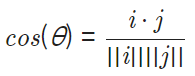

- 위 식에서 $s(w, A, B)$가 의미하는 것은 target에 있는 단어 $w$가 두 attribute 셋에 속한 단어들과의 유사도의 평균 값이 얼마나 차이 나는지를 측정한다.
    - 즉, 개별 단어 $w$가 개념축에 대해 가지는 편향성을 계산한 값이다.
    - 이는 -2에서 2 사이 값을 가지며, 절대값이 클수록 $w$는 개념축에 대해 편향성을 가진다는 뜻이다.
    
![image](https://user-images.githubusercontent.com/80008411/136647710-c9b1557f-7d3b-4f0a-bf7a-1d34aebe8b18.png)

- 식의 분자는 target X, Y에 속하는 각 단어 x, y들이 개념축 A-B에 대해 가지는 편향성을 각각 평균 내서 뺀 차이이다.
- 즉 X에 속하는 단어들과 Y에 속하는 단어들이 A-B 개념축에 대해 가지는 편향성의 정도가 뚜렷이 차이 날수록 이 WEAT score 식의 분자값의 절대값이 커진다.
- 이 값을 X, Y에 속하는 모든 단어들이 가지는 편향성 값의 표준 편차로 normalize한 값이 최종 WEAT score가 된다.

## 3. WEAT 구현하기

- 1) 두 개의 target 단어 셋 X, Y와 두 개의 attribute 단어 셋 A, B를 정의한다.
    - 이때 두 개의 target 셋의 크기가 같아야 하고, 두 개의 attribute 셋의 크기도 같아야 한다.

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [2]:
target_X = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
target_Y = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}
attribute_A = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
attribute_B = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

In [3]:
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])

print(X)
print(Y)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]


In [4]:
A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])

print(A)
print(B)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


In [5]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

print(s(target_X['장미'], A, B))
# attribute_A에 더 가깝다 (양수)

0.6457646122337399


In [6]:
print(s(target_Y['거미'], A, B))
# attribute_B에 더 가깝다 (음수)

-0.794002342033094


In [7]:
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

[0.29551989 0.51723181 0.26499096 0.50924109]
0.397


In [8]:
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[-0.44713039 -0.28310853 -0.33144878 -0.26030641]
-0.33


In [9]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

print(round(weat_score(X, Y, A, B), 3))
# score가 꽤 높게 나옴
# 즉 꽃은 유쾌한 단어와 상대적으로 가깝고, 곤충은 불쾌한 단어와 가까움

1.932


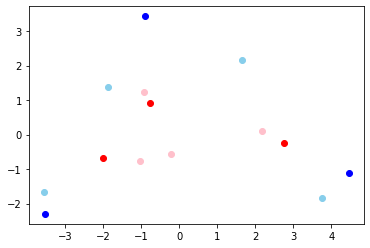

In [11]:
# 시각화해서 살펴보기
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')
# 파란 점 A와 하늘 점 X가 가깝고
# 빨간점 B와 핑크 점 Y가 가깝다

## 4. Pre-trained Word Embedding에 WEAT 적용하기

- [GoogleNews-vectors-negative300.bin.gz](https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download)

In [12]:
!mkdir -p ~/aiffel/aiffel_projects/goingdeeper/GD6_weat
!ln -s ~/data/* ~/aiffel/aiffel_projects/goingdeeper/GD6_weat
!cd ~/aiffel/aiffel_projects/goingdeeper/GD6_weat
!ls -l

total 48
drwxr-xr-x 4 root root  4096 Sep 24 06:28 GD1_text_preprocess
drwxr-xr-x 5 root root  4096 Sep 28 13:34 GD2_sp_tokenizer
drwxr-xr-x 4 root root  4096 Sep 30 07:16 GD3_topic_modeling
drwxr-xr-x 4 root root  4096 Oct  2 10:07 GD4_reuters_classification
drwxr-xr-x 3 root root  4096 Oct  6 08:48 GD5_word_embedding
-rw-r--r-- 1 root root 24258 Oct  9 08:30 GD6.ipynb
drwxr-xr-x 2 root root  4096 Oct  9 08:31 GD6_weat


In [13]:
!pip install gensim

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [14]:
import os
from gensim.models import KeyedVectors

data_dir = '~/aiffel/aiffel_projects/goingdeeper/GD6_weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [15]:
w2v

In [16]:
# print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

500000
300
(500000, 300)


In [17]:
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [18]:
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

In [19]:
w2v.most_similar(positive=['family'])

[('relatives', 0.6662653088569641),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894997596741),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065612435340881),
 ('aunt', 0.5811319947242737),
 ('grandparents', 0.5762072205543518),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

In [20]:
w2v.most_similar(positive=['school'])

[('elementary', 0.7868632078170776),
 ('schools', 0.7411909103393555),
 ('elementary_schools', 0.6597153544425964),
 ('kindergarten', 0.6529811024665833),
 ('eighth_grade', 0.6488089561462402),
 ('School', 0.6477997303009033),
 ('teacher', 0.63824063539505),
 ('students', 0.6301522850990295),
 ('classroom', 0.6281620264053345),
 ('Schools', 0.6172096133232117)]

In [21]:
# WEAT로 편향성 확인하기
target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)
# 과학과 관련된 단어가 남성 관련 단어와 가깝고
# 예술 관련 단어가 여성 관련 단어와 가깝다

1.2624874

In [22]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)
# target_X는 attribute_A와, target_Y는 attribute_B와 가깝다
# 단어의 의미를 잘 파악했다고 볼 수 있다.

1.6909266

In [23]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)
# 0에 가깝게 나타남
# 유사하다고 보기 어렵다는 의미

-0.05137869

## 5. 직접 워드 임베딩을 만들어서 WEAT 적용하기

- 1) 형태소 분석기를 이용해 명사 추출하기
- 2) 추출된 단어들로 임베딩 모델 만들기
- 3) TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
- 4) 임베딩 모델과 단어 셋으로 WEAT score 구하기

- 데이터셋: [synopsis.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/synopsis.zip)

In [24]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/synopsis.zip
!mv synopsis.zip ~/aiffel/aiffel_projects/goingdeeper/GD6_weat
!cd ~/aiffel/aiffel_projects/goingdeeper/GD6_weat && unzip synopsis.zip

--2021-10-09 08:45:46--  https://aiffelstaticprd.blob.core.windows.net/media/documents/synopsis.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18399462 (18M) [application/x-zip-compressed]
Saving to: ‘synopsis.zip’

synopsis.zip        100%[===================>]  17.55M  6.02MB/s    in 2.9s    

2021-10-09 08:45:50 (6.02 MB/s) - ‘synopsis.zip’ saved [18399462/18399462]

Archive:  synopsis.zip
  inflating: synopsis.txt            
  inflating: synopsis_SF.txt         
  inflating: synopsis_action.txt     
  inflating: synopsis_adult.txt      
  inflating: synopsis_adventure.txt  
  inflating: synopsis_animation.txt  
  inflating: synopsis_art.txt        
  inflating: synopsis_comedy.txt     
  inflating: synopsis_crime.txt      
  inflating: synopsis_

In [28]:
!pip install konlpy

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [27]:
with open(os.getenv('HOME')+'/aiffel/aiffel_projects/goingdeeper/GD6_weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

#### 1) 형태소 분석기를 이용해 명사 추출하기

In [30]:
from konlpy.tag import Okt

okt = Okt()
tokenized = []

with open(os.getenv('HOME')+'/aiffel/aiffel_projects/goingdeeper/GD6_weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        
        res = []
        for w in words:
            if w[1] in ['Noun']:
                res.append(w[0])
            tokenized.append(res)

In [31]:
print(len(tokenized))

3168454


#### 2) 추출된 결과로 임베딩 모델 만들기

In [32]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('이야기', 0.6233843564987183),
 ('작품', 0.5727538466453552),
 ('픽션', 0.5296003222465515),
 ('접점', 0.5202867388725281),
 ('영화로', 0.5183959603309631),
 ('논픽션', 0.4999814033508301),
 ('감독', 0.4907528758049011),
 ('절제', 0.49023956060409546),
 ('실존', 0.4902290105819702),
 ('실재', 0.48447084426879883)]

In [33]:
model.wv.most_similar(positive=['사랑'])

[('자신', 0.6421274542808533),
 ('그녀', 0.6392653584480286),
 ('그', 0.5937655568122864),
 ('것', 0.5801700949668884),
 ('아지만', 0.5726699233055115),
 ('소라치', 0.57231605052948),
 ('관현악', 0.5616066455841064),
 ('시작', 0.5560080409049988),
 ('친구', 0.5476680994033813),
 ('기사철십자훈장', 0.5367093086242676)]

In [34]:
model.wv.most_similar(positive=['연극'])

[('공연', 0.5264928340911865),
 ('콜렉티브', 0.5262086391448975),
 ('뮤지컬', 0.5106148719787598),
 ('이인근', 0.5048108100891113),
 ('권은영', 0.5007545948028564),
 ('영화감독', 0.4917135536670685),
 ('멜로드라마', 0.48778069019317627),
 ('보집', 0.48620110750198364),
 ('군더더기', 0.48384299874305725),
 ('제작', 0.4615655243396759)]

#### 3) TF-IDF 로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

- 예술 영화와 상업 영화라는 구분을 target으로 삼고, 드라마 장르와 액션 장르라는 구분을 attribute으로 삼아서 WEAT score를 계산해보자.
- 즉 드마라 장르는 예술영화 성격이 강하고, 액션 장르는 상업 영화 성격이 강할 것이라는 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지 측정해보는 것.
- 영화 구분
    - synopsis_art.txt : 예술영화
    - synopsis_gen.txt : 일반영화(상업영화)
    - 그 외는 독립영화 등으로 분류됩니다.
- 장르 구분
    - synopsis_SF.txt: SF
    - synopsis_가족.txt: 가족
    - synopsis_공연.txt: 공연
    - synopsis_공포(호러).txt: 공포(호러)
    - synopsis_기타.txt: 기타
    - synopsis_다큐멘터리.txt: 다큐멘터리
    - synopsis_드라마.txt: 드라마
    - synopsis_멜로로맨스.txt: 멜로로맨스
    - synopsis_뮤지컬.txt: 뮤지컬
    - synopsis_미스터리.txt: 미스터리
    - synopsis_범죄.txt: 범죄
    - synopsis_사극.txt: 사극
    - synopsis_서부극(웨스턴).txt: 서부극(웨스턴)
    - synopsis_성인물(에로).txt: 성인물(에로)
    - synopsis_스릴러.txt: 스릴러
    - synopsis_애니메이션.txt: 애니메이션
    - synopsis_액션.txt: 액션
    - synopsis_어드벤처.txt: 어드벤처
    - synopsis_전쟁.txt: 전쟁
    - synopsis_코미디.txt: 코미디
    - synopsis_판타지.txt: 판타지

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    
    with open(os.getenv('HOME') + '/aiffel/aiffel_projects/goingdeeper/GD6_weat/' + file_name, 'r') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem=True, norm=True)
            
            for word in tokenlist:
                if word[1] in ['Noun']:
                    result.append((word[0]))
        return ' '.join(result)

In [46]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [47]:
type(art)

str

In [48]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [50]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [51]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [52]:
# 각 단어 셋이 중복되지 않도록 중복 단어는 제외하고
# 상위 n개의 단어를 추출
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [53]:
# 추출된 단어 보기
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [54]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [55]:
# 장르별 대표 단어 추출
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

In [56]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


In [57]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(6, 33151)


In [58]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

드라마: 자신, 영화제, 그녀, 사람, 사랑, 위해, 영화, 시작, 국제, 남자, 친구, 이야기, 여자, 아버지, 엄마, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남자, 남편, 여자, 사람, 친구, 위해, 마음, 섹스, 결혼, 서로, 아내, 
액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 친구, 모든, 목숨, 사실, 세계, 가족, 
코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
전쟁: 전쟁, 위해, 전투, 시작, 작전, 독일군, 부대, 독일, 윈터스, 자신, 사람, 공격, 임무, 연합군, 병사, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 남자, 가족, 영화, 하나, 
